In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 16
learning_rate = .005
num_epochs = 50

In [3]:
data = torch.randint(-9, 10, (10000, 2)).float()
labels = torch.sum(data, axis=1).long() + 18

print(data.shape)
print(labels.shape)

torch.Size([10000, 2])
torch.Size([10000])


In [5]:
train_part, devset_part, train_labels_part, devset_labels_part = train_test_split(data, labels, test_size=.2)
devset_part, test_part, devset_labels_part, test_labels_part = train_test_split(devset_part, devset_labels_part, test_size=.5)

train_data = TensorDataset(train_part, train_labels_part)
devset_data = TensorDataset(devset_part, devset_labels_part)
test_data = TensorDataset(test_part, test_labels_part)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
devset_loader = DataLoader(devset_data, batch_size=devset_data.tensors[0].shape[0])

In [6]:
def create_model():
    class ModelCalculator(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2, 25)
            self.fc = nn.Linear(25, 25)
            self.output = nn.Linear(25, 37)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc(x))
            
            return self.output(x)
        
    model = ModelCalculator()    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate)
    
    return model, loss_fun, optimizer

In [7]:
def train_model():
    
    best_model = {
        "Accuracy": 0,
        "Epoch": 0,
        "Model_state": None
    }
    losses = np.zeros(num_epochs)
    train_acc = []
    devset_acc = []
    
    model, loss_fun, optimizer = create_model()
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        batch_acc = []
        
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_fun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            
            predictions = torch.argmax(yHat, axis=1)
            accuracy = 100*torch.mean((predictions == y).float())
            batch_acc.append(accuracy)
            
        losses[epoch] = np.mean(batch_losses)
        train_acc.append(np.mean(batch_acc))
        
        model.eval()
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = model(X)
        
        devset_acc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y).float()))
        
        if devset_acc[-1] > best_model["Accuracy"]:
            best_model["Accuracy"] = devset_acc[-1]
            best_model["Model_state"] = model.state_dict()
            best_model["Epoch"] = epoch
        
    return losses, train_acc, devset_acc, best_model

In [8]:
losses, train_acc, devset_acc, best_model = train_model()

print(f"The best accuracy: {best_model['Accuracy']}% on {best_model['Epoch']} epoch")

The best accuracy: 100.0 on 13 epoch


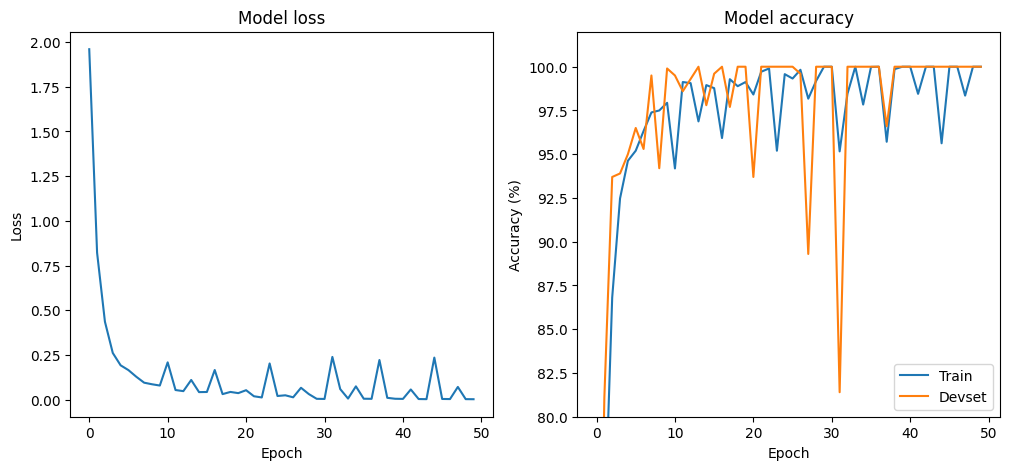

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title("Model loss")

ax[1].plot(train_acc, label='Train')
ax[1].plot(devset_acc, label='Devset')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Model accuracy')
ax[1].set_ylim([80, 102])
ax[1].legend()

plt.show()

In [10]:
for i in range(10):
    losses, train_acc, devset_acc, best_model = train_model()
    print(f"Train accuracy: {train_acc[-1]:.2f}%, Devset accuracy: {devset_acc[-1]:.2f}%")

Train accuracy: 100.00%, Devset accuracy: 98.60%
Train accuracy: 100.00%, Devset accuracy: 100.00%
Train accuracy: 100.00%, Devset accuracy: 100.00%
Train accuracy: 98.32%, Devset accuracy: 91.90%
Train accuracy: 100.00%, Devset accuracy: 100.00%
Train accuracy: 98.71%, Devset accuracy: 99.10%
Train accuracy: 98.82%, Devset accuracy: 72.90%
Train accuracy: 99.66%, Devset accuracy: 99.90%
Train accuracy: 93.36%, Devset accuracy: 99.60%
Train accuracy: 100.00%, Devset accuracy: 100.00%


In [11]:
model2 = create_model()[0]
model2.load_state_dict(best_model["Model_state"])

<All keys matched successfully>

In [12]:
X, y = test_data.tensors
yHat = model2(X)

print(f"Accuracy on test data: {100*torch.mean((torch.argmax(yHat, axis=1) == y).float()):.2f} %")

Accuracy on test data: 100.00 %


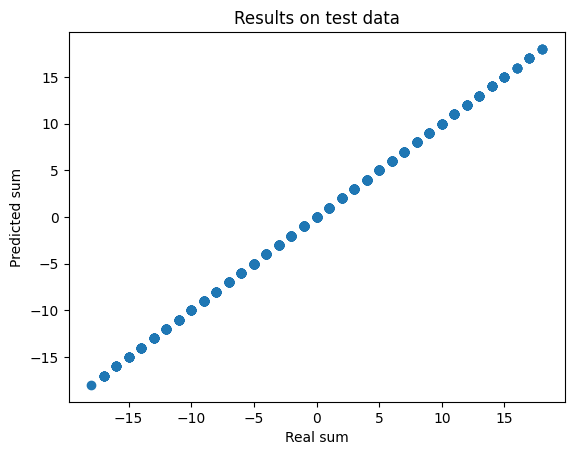

In [13]:
predictions = torch.argmax(yHat, axis=1)
plt.scatter(y-18, predictions.detach()-18)
plt.xlabel('Real sum')
plt.ylabel('Predicted sum')
plt.title('Results on test data')
plt.show()

In [14]:
def get_sum_of_two_digits(a: int, b: int):
    input_ = torch.tensor([a, b]).float()
    predictions = torch.argmax(model2(input_)) - 18
    print(f"{a}+{b}={predictions}")

In [19]:
get_sum_of_two_digits(-2, -5)

-2+-5=-7


In [16]:
#torch.save(model2.state_dict(), 'Smart_calculator.pt')